In [3]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import matplotlib.pyplot as plt
import xarray as xr

We will demonstrate our method with the 22.5 degree.
However, using for-loop or map function, you can test various angles between 0 and 45.

In [4]:
pi = np.pi
choices = [pi/4*(x+1)/100 for x in range(100)]
# The angle we will test here is pi/8
angle = np.pi/8

The linescan image with which we will demonstrate the rotate-and-cut algorithm is the linescan image with the id 100.

In [5]:
df = dd.read_csv('train_100.csv')

In [6]:
df = df.loc[:,['x','y','linescan']]

In [7]:
df = df.compute()
# org_df = df.copy()
# min_max_org = df[df.linescan.gt(0)].loc[:, ['x', 'y']].apply([np.min, np.max]).to_numpy()

Below is the plot of the linescan image

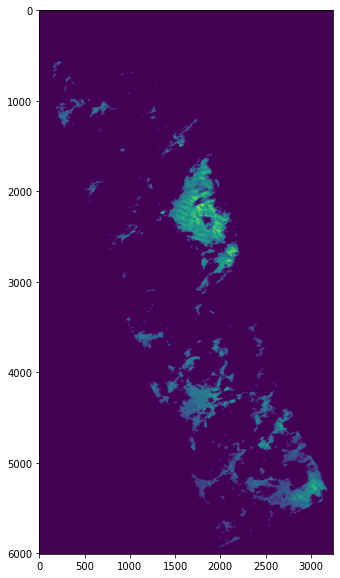

In [8]:
im = df.pivot_table(index = 'y', columns = 'x', values = 'linescan', fill_value = 0).to_numpy()
fig = plt.figure(figsize = (10,10))
plt.imshow(im)

Below is the rotation matrix with the given angle.   
As an example, let's test the 22.5 degree

In [9]:
rot = np.array([[np.cos(angle), np.sin(angle)],[-np.sin(angle), np.cos(angle)]])

We will rotate the image by multiplying this rotation matrix to our image

In [10]:
df[['x','y']] = df[['x','y']].dot(rot).round(0).astype(int)
df[['x','y']] = (df[['x','y']]).round(-1)

The transformed coordinate will not be uniform, and that is why at the end we rounded them.   
However, this also gives us duplicate values for a given coordinate.   
To deal with this, we acquire the maximum linescan value

In [12]:
df = df.groupby(['x','y']).agg(np.max).reset_index()

In [13]:
im = df.pivot_table(index = 'y', columns = 'x', values = 'linescan', fill_value = 0).to_numpy()

Below is the image of the linescan image after rotation.

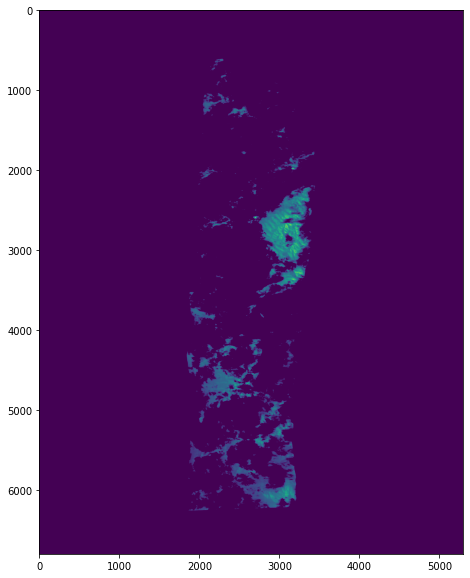

In [14]:
fig = plt.figure(figsize = (10,10))
plt.imshow(im)

Now, we want to cut off the area outside of the frame.    
To do so, you find the minimum and maximum coordinates of the pixes whose linescan values are greater than 0.

In [15]:
min_max = df[df.linescan.gt(0)].loc[:, ['x', 'y']].apply([np.min, np.max]).to_numpy()

In [16]:
min_max

array([[-1802280,  5545240],
       [-1786270,  5601660]])

Since our image is not perfectly square, we cut-off more points than the minimum and maximum

In [17]:
new_df = df.loc[df.x.ge(-1803000) & df.x.le(-1787000) & df.y.ge(5546000) & df.y.le(5601000), :]

In [18]:
new_im = new_df.pivot_table(index = 'y', columns = 'x', values = 'linescan', fill_value = 0)

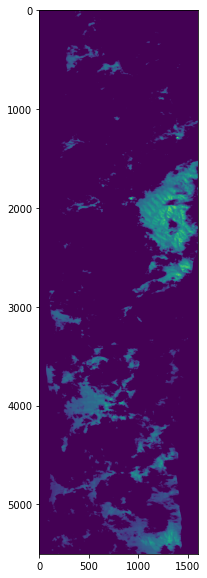

In [19]:
fig = plt.figure(figsize = (10,10))
plt.imshow(new_im)

In the actual rotataion and cutoff step, we tested 51 different angles and checked wich rotation is ideal.   

After finding the best angle, we cut-off approximately 5% from the top-and-bottom and the right-and-left sides of the frame to make sure our data does not include the data outside of the frame.

Finally, we rotate them back and retained the original coordinates.